# Collocation Extraction Methodologies Compared

In corpus linguistics, a collocation is a series of words or terms that co-occur more often than would be expected by chance. In phraseology, a collocation is a type of compositional phraseme, meaning that it can be understood from the words that make it up. This contrasts with an idiom, where the meaning of the whole cannot be inferred from its parts, and may be completely unrelated. 

An example of a phraseological collocation is the expression strong tea.[1] While the same meaning could be conveyed by the roughly equivalent powerful tea, this expression is considered excessive and awkward by English speakers. Conversely, a corresponding expression in technology, powerful computer, is preferred over strong computer.

* https://en.wikipedia.org/wiki/Collocation

#### This notebook examines the different ways a collocation can be calculated (Loglikelihood ratio of bigram probabilities, Pointwise mutual information) and some problems and solutions for extending beyond bigram collocations.

In [4]:
from collections import Counter
from random import sample

import stanza
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk import ngrams
from nltk.corpus import brown
from tqdm import tqdm
from scipy.stats import binom, chi2

### Binomial Probabilty Mass Function used for likelihood matching
Often, for computing the probability of a collocation, we assume a binomial distribution and coincedental matching is an independent probability. Here's quick refresher with a concrete example.

Suppose a die is tossed 5 times. 

What is the probability of getting exactly 2 fours?

Solution: 
* This is a binomial experiment in which the number of *trials* is equal to 5,
* the number of *successes* is equal to 2,
* and the *probability of success* on a single trial is 1/6 or about 0.167.
* Therefore, the binomial probability is:         
binom.pmf(2, 5, 0.167)

0.16120107977393003

* https://en.wikipedia.org/wiki/Binomial_distribution

### Log-Likelihood Ratio Test
The Log-likelihood ratio is the ratio of two hypothesis on the probability of words occuring together; a formulation of the Null hypothesis and a hypothesis based on observed values. These hypothesis and ratios allow us to formulate the confidence with which we believe a set of words form a collocation.

$log \lambda = log \frac{L(H_0)}{L(H_1)}$

_Hypothesis 0_

$P(w^2 | w^1) = p = P(w^2 | \neg w^1)$ 

A formulation of independence (the occurrence of $w^2$ is independent of previous occurrence of $w^1$); our Null Hypothesis.

_Hypothesis 1_

$P(w^2 | w^1) = p_1 \neq p_2 = P(w^2 | \neg w^1)$ 

A formulation of dependence, and good evidence of a collocation.

Using maximum Likelihood estimates for $p$, $p_1$, $p_2$, and $c_1$, $c_2$, $c_{12}$ as the number of occurrences for $w^1$, $w^2$, $w^{12}$ in the corpus

$P = \frac{c_2}{N}$
$P_1 = \frac{c_{12}}{c_1}$
$P_2 = \frac{c_2 - c_{12}}{N - c_1}$

Using the binomial probabilties these are formulated as:

$\Large log \frac{b(c_{12}; c_1, p) b(c_2 - c_{12}; N - c_1, p)}{b(c_{12}; c_1, p_1) b(c_2 - c_{12}; N - c_1, p_2)}$

in Manning and Schütze (1999) they simplify as:

$log L(c_{12}; c_1, p) + log L(c_2 - c_{12}; N - c_1, p) - log L(c_{12}; c_1, p_1) - log L(c_2 - c_{12}; N - c_1, p_2)$

The notation may be less confusing if you think in terms:

$p = P(w^2)$

$p_1 = P(w^2|w^1)$

$p_2 = P(w^2|\neg w^1)$

The entire space is the pairs ($p_1, p_2$) for the probability of $w^2$ occurring when $w^1$ preceded $p_1$, and $w^2$ occurring when a different word preceded ($p_2$).

see also: https://en.wikipedia.org/wiki/Likelihood-ratio_test

### Degree of freedom is calculated by using the following formula:
* DF = (r-1)(c-1)
* DF = Degree of freedom
* r = number of rows
* c = number of columns

In null hypothesis significance testing, the p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis.
* https://en.wikipedia.org/wiki/P-value

In [6]:
def loglikelihood_ratio(c1, c2, c12, N):
    """
    Compute the ratio of two hypotheses of likelihood and return the ratio.
    
    Under the Independence hypothesis (H0) we assume that there is 
    no association between w1 and w2, i.e. they are independent: 
    let P(w1) and P(w2) be probabilities that 
    a random token in a text is w1 and w2 respectfully and 
    P(w1,w2) is the probability that (w1,w2) occur together in the text 
    (i.e. one follows another) so under H0, P(w1,w2) = P(w1)P(w2)
    we can compute the observed probability of P(w1,w2) 
    and compare it with the probability under H0
    if these probabilities are significantly different from each other,
    then (w1,w2) is a collocation.
    
    The formula here and test verification values are taken from 
    Manning & Schūtze _Foundations of Statistical Natural Language Processing_ p.172-175
    
    Parameters:
    c1: count of word 1
    c2: count of word 2
    c12: count of bigram (w1, w2)
    N: the number of words in the corpus
    
    The value: -2 * loglikelihood_ratio is asymptotically Chi-squared distributed 
    so we can use Chi-squared table values to test the Null-Hypothesis
    against the second Hypothesis--the observed values--as represented by the ratio.
    
    The following example is taken from Manning and Schütze _Statistical NLP_ p.107
    # 1990 NYT data
    >>> N = 14_307_668
    >>> c1 = 932 # powerful
    >>> c2 = 934 # computers
    >>> c12 = 10 # bigram count 
    >>> res = -2 * loglikelihood_ratio(c1, c2, c12, N)
    >>> res 
    82.37586050140558
    >>> # e.g. for a alpha value of: 0.005, 
    >>> # 1 Degree of freedom requires a chi-squared value of 7.88
    >>> from scipy.stats import chi2
    >>> print ('p-value: %.30f' % chi2.sf(res, 1)) # 1 degrees of freedom
    p-value: 0.000000000000000000112519634099
    
    """
    p = c2 / N
    p1 = c12 / c1
    p2 = (c2 - c12) / (N - c1)   
    # We proactively trap a runtimeWarning: divide by zero encountered in log,
    # which may occur with extreme collocations
    import warnings
    with warnings.catch_warnings(): # this will reset our filterwarnings setting
        warnings.filterwarnings('error')
        try:
            return (np.log(binom.pmf(c12, c1, p)) 
                    + np.log(binom.pmf(c2 - c12, N - c1, p)) 
                    - np.log(binom.pmf(c12, c1, p1) )
                    - np.log(binom.pmf(c2 - c12, N - c1, p2)))             
        except Warning:
            return np.inf 

In [7]:
# 1990 NYT data
N = 14_307_668
c1 = 932 # powerful
c2 = 934 # computers
c12 = 10
res = -2 * loglikelihood_ratio(c1, c2, c12, N)
# Note: we multiply the ratio by -2 and 
# the value is directly comparable to Chi-squared values
# e.g. for a alpha value of: 0.005, 1 Degree of freedom 
# requires a chi-squared value of 7.88
p = chi2.sf(res, 1) # 1 degrees of freedom
print(res, 'p-value: %.30f' % p)
#  82.37586050140558 p-value: 0.000000000000000000112519634099

82.37586050140521 p-value: 0.000000000000000000112519634099


### Null Hypothesis: probability of a bigram is just the product of the individual probabilities.

In [8]:
pone = c1/N
ptwo = c2/N
res = binom.pmf(c12, min(c1,c2), pone * ptwo)
res

2.50959954316171e-61

### Collocation: probability of a bigram is the conditional probability of the P(B|A)

In [9]:
pone = c1/N
ptwo = c2/N
pbg = c12/N
res2 = binom.pmf(c12, min(c1, c2), pbg / pone)
res2
# p(A|B) = P(AB) / P(B)
# P(B|A) = P(AB) / P(A)
# P(C | AB ) = P(ABC) / P(AB)

0.12578655488346452

##### Note: Loglikelihood calculation fails with zero divide on "of the".  
##### Hence, we will proactively trap a runtimeWarning: divide by zero encountered in log, which may occur with extreme collocations

In [10]:
# e.g. Brown News corpus 
c1 = 2849 # of
c2 = 5580 # the
c12 = 844 
N =100554
loglikelihood_ratio(c1, c2, c12, N)

inf

In [11]:
def calc_probabilities(c1:int, c2:int, c12:int, N:int):
    """
    :param c1: the count of unigram x
    :param c2: the count of unigram y
    :param c12: the number of times that unigrams x and y co-occur
    :param N: the total number of words in the observed corpus
    
    :return tuple of probabilities:
    (not x, not y), P(x), P(y), P(xy)
    """
    zero_zero = 1 - (((c1 - c12) / N ) +( (c2 - c12) / N) + (c12 / N))
    one_zero = (c1 - c12) / N
    zero_one = (c2 - c12) / N
    one_one = c12 / N
    return zero_zero, one_zero + one_one, zero_one + one_one, one_one

### PMI - Pointwise Mutual Information

$pmi(x;y)\equiv log \frac{p(x,y)}{p(x)p(y)}$

Pointwise mutual information can be normalized between [-1,+1] resulting in -1 (in the limit) for never occurring together, 0 for independence, and +1 for complete co-occurrence.

$npmi(x;y) = \frac{pmi(x;y)}{h(x,y)}$

where h(x,y)
is the joint self-information, which is estimated as 
$-\log _{2}p(X=x,Y=y)$

see also: https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [12]:
def pmi(c1, c2, c12, N):
    """
    Calculate the pointwise mutual information for the word and bigram counts
    
    Parameters:
    c1: count of word 1
    c2: count of word 2
    c12: count of bigram (w1,w2)
    N: the number of words in the corpus
    
    The following example is from Wikipedia data table at:
    https://en.wikipedia.org/wiki/Pointwise_mutual_information
    >>> c1 = 3501  # los
    >>> c2 = 2808 # angeles 
    >>> c12 = 2791
    >>> N  = 50_000_952
    >>> pmi(c1, c2, c12, N)
    9.560676150647117
    
    """    
    p_not_x_not_y, px, py, pxy = calc_probabilities(c1, c2, c12, N)
    return np.log(pxy / (px * py))

def npmi(c1, c2, c12, N):
    """
    Calculate the normalized pointwise mutual information for the word and bigram counts.
    Normalized between [-1,+1] resulting in:
    * -1 (in the limit) for never occurring together
    * 0 for independence
    * +1 for complete co-occurrence.
    
    Parameters:
    c1: count of word 1
    c2: count of word 2
    c12: count of bigram (w1,w2)
    N: the number of words in the corpus
        
    >>> c1 = 3501  # los
    >>> c2 = 2808 # angeles 
    >>> c12 = 2791
    >>> N  = 50_000_952
    >>> npmi(c1, c2, c12, N)
    0.49398779748399313
    
    """    
    p_not_x_not_y, px, py, pxy = calc_probabilities(c1, c2, c12, N)
    pmi_val = np.log(pxy / (px * py))
    return pmi_val / - np.log(px * py)

In [13]:
c1 = 3501  # los
c2 = 2808 # angeles 
c12 = 2791
N  = 50_000_952
pmi(c1, c2, c12, N)
# 9.560676150647117

9.560676150647117

In [14]:
npmi(c1, c2, c12, N)

0.49398779748399313

## Corpus Exploration
We'll look at the Brown News Corpus, which is very small--only 100,554 tokens--and this small corpus will help show the strengths and weaknesses of our collocation algorithms.

We'll add one more way of detecting/filtering collocations, by using Stanza for POS tagging. The collocation / POS tag patterns are from Justeson and Katz 1995, and their original list is: 
* A N
* N N
* A A N
* A N N
* N A N
* N N N
* N P N 

(A = Adj, N = Noun, P = Preposition).

Note: Wikipedia lists a different set: There are about six main types of collocations: adjective + noun, noun + noun (such as collective nouns), verb + noun, adverb + adjective, verbs + prepositional phrase (phrasal verbs), and verb + adverb. 

In [15]:
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos',
                      use_gpu=False, tokenize_batch_size=1024)

2021-12-14 23:14:50 INFO: Downloading default packages for language: en (English)...
2021-12-14 23:14:52 INFO: File exists: /Users/todd/stanza_resources/en/default.zip.
2021-12-14 23:15:02 INFO: Finished downloading models and saved to /Users/todd/stanza_resources.
2021-12-14 23:15:02 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2021-12-14 23:15:02 INFO: Use device: cpu
2021-12-14 23:15:02 INFO: Loading: tokenize
2021-12-14 23:15:02 INFO: Loading: pos
2021-12-14 23:15:03 INFO: Done loading processors!


In [16]:
word_counter = Counter() # brown.words(categories='news'))
# we wish to filter out punctuation, so this isn't enough:
# bigrams = [list(ngrams(tmp, 2)) for tmp in brown.sents(categories='news')]
bigrams = []
trigrams = []
words_upos = {}

COLL_POS_TG = {('ADJ', 'ADJ', 'NOUN'),
                ('ADJ', 'NOUN', 'NOUN'), 
                ('NOUN', 'ADJ', 'NOUN'),               
                ('NOUN', 'NOUN', 'NOUN'), 
                ('NOUN', 'ADP', 'NOUN'),                
                ('PROPN', 'PROPN', 'PROPN')}

COLL_POS_BG = {('ADJ', 'NOUN'), # these are the top 3 required
                ('NOUN', 'NOUN'), 
                ('PROPN', 'PROPN'),                
                ('ADJ', 'ADJ'),
                # The following are derived from the trigram POS tags, 
                # and we have to capture them to compute probabilities               
                ('NOUN', 'ADP'),                
                ('ADP', 'NOUN'),                               
                ('NOUN', 'ADJ')}

for sent in tqdm(brown.sents(categories='news'),
                 total=len(brown.sents(categories='news'))):
    clean_sent = []
    clean_sent_upos = []
    # This will be a coarse grain mapping of POS tags
    doc = nlp(' '.join(sent))
    for sentence in doc.sentences:
        for word in sentence.words:
            words_upos[word.text] = word.upos
            if word.text.isalpha():
                clean_sent.append(word.text)    
                word_counter.update({word.text: 1})
                clean_sent_upos.append(word.upos)
    candidate_bigrams = list(ngrams(clean_sent, 2))
    candidate_trigrams = list(ngrams(clean_sent, 3))
    for idx, can in enumerate(list(ngrams(clean_sent_upos, 2))):
        if can in COLL_POS_BG:            
            bigrams.append(candidate_bigrams[idx])
    for idx, can in enumerate(list(ngrams(clean_sent_upos, 3))):
        if can in COLL_POS_TG:            
            trigrams.append(candidate_trigrams[idx])

bigram_counter = Counter()
for bg in bigrams:
    bigram_counter.update({bg: 1})
    
trigram_counter = Counter()
for tg in trigrams:
    trigram_counter.update({tg:1})

# del bigrams, trigrams

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4623/4623 [05:02<00:00, 15.30it/s]


In [17]:
candidate_bigrams[2]

('one', 'of')

In [18]:
candidate_trigrams[8]

('National', 'Library', 'Week')

In [19]:
bigram_counter.most_common(10)

[(('per', 'cent'), 50),
 (('last', 'year'), 33),
 (('members', 'of'), 32),
 (('last', 'week'), 30),
 (('president', 'of'), 28),
 (('number', 'of'), 27),
 (('President', 'Kennedy'), 25),
 (('chairman', 'of'), 22),
 (('home', 'runs'), 22),
 (('part', 'of'), 19)]

In [20]:
trigram_counter.most_common(10)

[(('toll', 'road', 'bonds'), 8),
 (('home', 'rule', 'charter'), 5),
 (('years', 'in', 'prison'), 4),
 (('aged', 'care', 'plan'), 4),
 (('grants', 'to', 'states'), 4),
 (('board', 'of', 'directors'), 4),
 (('La', 'Dolce', 'Vita'), 4),
 (('potato', 'chip', 'industry'), 4),
 (('Catholic', 'higher', 'education'), 4),
 (('discrimination', 'in', 'employment'), 3)]

# Accurately estimating trigrams and bigrams
we don't have to create and store all the bigrams and trigrams to estimate their totals, as long as we know the number of sentences in the corpus, and the number of unigrams.

In [21]:
total_sents = len(brown.sents(categories='news'))
total_bigrams = sum(bigram_counter.values())
total_trigrams = sum(trigram_counter.values())
total_unigrams = sum(word_counter.values())
print(total_sents, total_bigrams, total_trigrams, total_unigrams)
# (4623, 81396, 76832, 86002)

4623 18747 3697 85270


In [22]:
est_bigrams = total_unigrams - total_sents
est_trigrams = total_unigrams - 2*(total_sents)
est_bigrams / total_bigrams, est_trigrams / total_trigrams
# (0.9997911445279867, 0.9990108288213244)

(4.301861631194324, 20.563700297538546)

In [23]:
len(bigram_counter), len(trigram_counter)
# (54578, 71695)

(15038, 3550)

In [24]:
trigram_counter.most_common(15)

[(('toll', 'road', 'bonds'), 8),
 (('home', 'rule', 'charter'), 5),
 (('years', 'in', 'prison'), 4),
 (('aged', 'care', 'plan'), 4),
 (('grants', 'to', 'states'), 4),
 (('board', 'of', 'directors'), 4),
 (('La', 'Dolce', 'Vita'), 4),
 (('potato', 'chip', 'industry'), 4),
 (('Catholic', 'higher', 'education'), 4),
 (('discrimination', 'in', 'employment'), 3),
 (('Speaker', 'Sam', 'Rayburn'), 3),
 (('South', 'Viet', 'Nam'), 3),
 (('Prince', 'Souvanna', 'Phouma'), 3),
 (('civil', 'defense', 'program'), 3),
 (('fire', 'fighters', 'association'), 3)]

In [25]:
# N = sum(bigram_counter.values())
N = sum(word_counter.values())
data = []
for bigram in bigram_counter.keys():
    w1, w2 = bigram
    c1 = word_counter[w1]
    c2 = word_counter[w2]        
    npmi_val = npmi(c1, c2, bigram_counter[bigram], N)
    loglikelihood_ratio_val = -2 * loglikelihood_ratio(c1, c2, bigram_counter[bigram], N)
    data.append({"w1": w1,
                    "w2": w2,
                    "w1w2_pos": f"{words_upos[w1]} {words_upos[w2]}",
                    "npmi": npmi_val,
                    "loglikelihood_ratio": loglikelihood_ratio_val,
                    "c1": c1,
                    "c2": c2,                
                    "bigram_cnt": bigram_counter[bigram],
                    "w1pos": words_upos[w1],                 
                    "w2pos": words_upos[w2]})
df = pd.DataFrame(data)

# Sorting by loglikelihood_ratio

In [53]:
# for a alpha value of: 0.005, 1 Degree of freedom requires a chi-squared value of 7.88
df.query('loglikelihood_ratio > 7.88 and c1 >2 and c2 >2').sample(10)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
2517,professional,posts,ADJ NOUN,0.432809,29.904074,10,5,2,ADJ,NOUN
13754,next,fall,ADJ NOUN,0.303898,8.019506,40,15,1,ADJ,NOUN
491,state,deaf,NOUN ADJ,0.312862,8.573055,97,5,1,NOUN,ADJ
14762,cooperative,movement,ADJ NOUN,0.406307,14.004512,3,12,1,ADJ,NOUN
14165,Byron,Rickards,PROPN PROPN,0.430458,15.709993,4,4,1,PROPN,PROPN
11567,High,blood,ADJ NOUN,0.395293,13.282395,17,3,1,ADJ,NOUN
580,utility,companies,NOUN NOUN,0.376429,11.980586,5,18,1,NOUN,NOUN
14109,Government,Defense,PROPN PROPN,0.367919,11.478318,23,5,1,PROPN,PROPN
5699,Thursday,June,PROPN PROPN,0.327795,9.192198,21,16,1,PROPN,PROPN
14152,age,boy,NOUN NOUN,0.342881,9.992428,12,19,1,NOUN,NOUN


# Sorting by NPMI

In [54]:
# it's commonly recommended to filter PMI values by unigrams with at least 3 occurences
df.query('c1 > 2 and c2 > 2 and bigram_cnt > 2 and npmi > 0').sample(10)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
124,establishment,of,NOUN ADP,0.253343,35.120483,7,2850,6,NOUN,ADP
4058,on,completions,ADP NOUN,0.321732,29.199831,658,3,3,ADP,NOUN
9397,beginning,of,NOUN ADP,0.199217,11.105044,7,2850,3,NOUN,ADP
6052,trip,to,NOUN PART,0.195250,10.291986,10,2125,3,NOUN,PART
1316,East,West,PROPN ADJ,0.390679,44.560445,22,26,4,PROPN,ADJ
4015,Last,year,ADJ NOUN,0.304879,21.692448,16,178,3,ADJ,NOUN
8121,in,sales,ADP NOUN,0.110732,4.407956,1896,52,4,ADP,NOUN
2571,head,of,NOUN ADP,0.212545,34.441728,26,2850,10,NOUN,ADP
1492,Souvanna,Phouma,PROPN PROPN,0.494340,82.734057,5,4,4,PROPN,PROPN
2923,performance,bond,NOUN NOUN,0.427460,41.749275,11,11,3,NOUN,NOUN


# Sorting by POS tags

In [55]:
df.query("w1w2_pos in ['NOUN NOUN', 'ADJ NOUN', 'PROPN PROPN', 'NOUN ADJ', " 
         " 'NOUN ADP', 'ADJ ADJ','ADP NOUN']").head(10)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
0,Fulton,County,PROPN PROPN,0.419954,75.185197,14,36,6,PROPN,PROPN
1,investigation,of,NOUN ADP,0.206101,15.167637,9,2850,4,NOUN,ADP
2,recent,primary,ADJ ADJ,0.327323,9.167252,20,17,1,ADJ,ADJ
3,primary,election,ADJ NOUN,0.343422,18.668591,17,38,2,ADJ,NOUN
4,in,presentments,ADP NOUN,0.251066,7.612668,1896,1,1,ADP,NOUN
5,charge,of,NOUN ADP,0.221895,31.499885,17,2850,8,NOUN,ADP
6,thanks,of,NOUN ADP,0.123974,1.730451,6,2850,1,NOUN,ADP
7,manner,in,NOUN ADP,0.193232,7.075228,7,1896,2,NOUN,ADP
8,September,October,PROPN PROPN,0.376429,11.928196,10,9,1,PROPN,PROPN
9,term,jury,NOUN NOUN,0.290850,7.409629,18,45,1,NOUN,NOUN


# Sorting by loglikelihood_ratio, and POS tags (without Proper Nouns)

In [56]:
# for a alpha value of: 0.005, 1 Degree of freedom requires a chi-squared value of 7.88
df.query("loglikelihood_ratio > 7.88 " 
         " and c1 > 2 and c2 > 2 and w1w2_pos in " 
         " ['NOUN NOUN', 'ADJ NOUN', 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ', 'ADP NOUN']"
        ).sort_values(by=['npmi', 'loglikelihood_ratio'], ascending=False).head(10)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
7905,magnetic,tape,ADJ NOUN,0.492887,63.031007,3,4,3,ADJ,NOUN
211,per,cent,ADP NOUN,0.491872,769.601616,61,52,50,ADP,NOUN
9055,potato,chip,NOUN NOUN,0.490466,96.627662,6,6,5,NOUN,NOUN
8046,collective,bargaining,ADJ NOUN,0.489033,162.815779,10,12,9,ADJ,NOUN
7896,data,processing,NOUN NOUN,0.485558,78.177368,4,7,4,NOUN,NOUN
4580,relative,merits,ADJ NOUN,0.480231,39.003530,3,3,2,ADJ,NOUN
9906,depletion,allowances,NOUN NOUN,0.480231,39.003530,3,3,2,NOUN,NOUN
7612,utility,pole,NOUN NOUN,0.473788,54.069549,5,5,3,NOUN,NOUN
3659,mound,chores,NOUN NOUN,0.472837,37.277461,3,4,2,NOUN,NOUN
7903,electronic,data,ADJ NOUN,0.472837,37.277461,3,4,2,ADJ,NOUN


In [57]:
df.query("loglikelihood_ratio > 7.88 " 
         " and c1 >2 and c2 >2 and w1w2_pos in " 
         " ['NOUN NOUN', 'ADJ NOUN', 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ', 'ADP NOUN']"
        ).sort_values(by=['loglikelihood_ratio'], ascending=False).head(10)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
211,per,cent,ADP NOUN,0.491872,769.601616,61,52,50,ADP,NOUN
1820,last,week,ADJ NOUN,0.392631,265.530790,161,93,30,ADJ,NOUN
977,last,year,ADJ NOUN,0.368604,250.974446,161,178,33,ADJ,NOUN
8046,collective,bargaining,ADJ NOUN,0.489033,162.815779,10,12,9,ADJ,NOUN
22,number,of,NOUN ADP,0.286063,156.366511,32,2850,27,NOUN,ADP
1763,vice,president,NOUN NOUN,0.445414,142.567836,11,54,10,NOUN,NOUN
1640,last,night,ADJ NOUN,0.366580,140.568827,161,65,17,ADJ,NOUN
320,members,of,NOUN ADP,0.249033,123.882829,70,2850,32,NOUN,ADP
952,social,security,ADJ NOUN,0.464201,123.555102,17,13,8,ADJ,NOUN
688,high,school,ADJ NOUN,0.390520,117.732428,52,67,12,ADJ,NOUN


In [58]:
N

85270

In [59]:
loglikefilter = len(df.query('loglikelihood_ratio > 7.88 and c1 >2 and c2 >2'))
loglike_pos_filter = len(df.query("loglikelihood_ratio > 7.88 and c1 >2 and c2 >2 and w1w2_pos in ['NOUN NOUN', 'ADJ NOUN', 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ','ADP NOUN']").sort_values(by=['npmi', 'loglikelihood_ratio'], ascending=False))
pos_filter = len(df.query("w1w2_pos in ['NOUN NOUN', 'ADJ NOUN', 'PROPN PROPN', 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ','ADP NOUN']"))
npmi_filter = len(df.query('c1 > 2 and c2 > 2 and bigram_cnt > 2 and npmi > 0'))

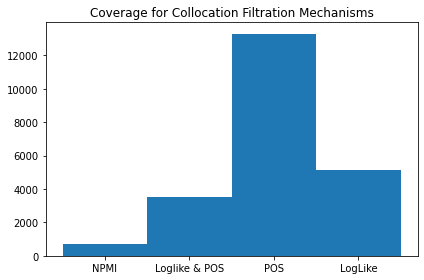

In [60]:
heights = [npmi_filter, loglike_pos_filter, pos_filter, loglikefilter]
labels = ["NPMI", "Loglike & POS", "POS", "LogLike"]
fig, ax = plt.subplots()
x = np.arange(len(labels)) 
width = 1
ax.bar(x, heights, width)
ax.set_title('Coverage for Collocation Filtration Mechanisms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.tight_layout()
plt.show()

## Filter by loglike_pos

In [61]:
loglike_pos_df = df.query("loglikelihood_ratio > 7.88 and " 
                          " c1 >2 and c2 >2 and w1w2_pos in ['NOUN NOUN', 'ADJ NOUN', "
                          " 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ','ADP NOUN']")
loglike_pos_df

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
1,investigation,of,NOUN ADP,0.206101,15.167637,9,2850,4,NOUN,ADP
2,recent,primary,ADJ ADJ,0.327323,9.167252,20,17,1,ADJ,ADJ
3,primary,election,ADJ NOUN,0.343422,18.668591,17,38,2,ADJ,NOUN
5,charge,of,NOUN ADP,0.221895,31.499885,17,2850,8,NOUN,ADP
14,possible,irregularities,ADJ NOUN,0.378783,12.261064,28,3,1,ADJ,NOUN
...,...,...,...,...,...,...,...,...,...,...
15016,inadequate,service,ADJ NOUN,0.358915,11.016435,4,37,1,ADJ,NOUN
15018,college,libraries,NOUN NOUN,0.321191,8.855464,18,22,1,NOUN,NOUN
15031,public,understanding,ADJ NOUN,0.338597,9.863899,51,5,1,ADJ,NOUN
15032,main,reasons,ADJ NOUN,0.397239,13.325174,4,12,1,ADJ,NOUN


## Filtering by NPMI

In [62]:
npmi_df = df.query('c1 > 2 and c2 > 2 and bigram_cnt > 2 and npmi > 0')
npmi_df

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
0,Fulton,County,PROPN PROPN,0.419954,75.185197,14,36,6,PROPN,PROPN
1,investigation,of,NOUN ADP,0.206101,15.167637,9,2850,4,NOUN,ADP
5,charge,of,NOUN ADP,0.221895,31.499885,17,2850,8,NOUN,ADP
13,reports,of,VERB ADP,0.187483,12.460307,12,2850,4,VERB,ADP
21,interest,in,NOUN ADP,0.193385,20.369824,33,1896,7,NOUN,ADP
...,...,...,...,...,...,...,...,...,...,...
14720,York,State,PROPN PROPN,0.296402,20.307167,54,63,3,PROPN,PROPN
14728,libraries,in,NOUN ADP,0.192605,15.254045,22,1896,5,NOUN,ADP
14902,in,member,ADP NOUN,0.114129,3.670967,1896,36,3,ADP,NOUN
14919,member,libraries,NOUN NOUN,0.378311,41.773555,36,22,4,NOUN,NOUN


In [63]:
llpidx = loglike_pos_df.index.tolist()
npmiidx = npmi_df.index.tolist()
overlap = len(set(llpidx) & set(npmiidx))
percent_overlap = overlap / max(len(loglike_pos_df), len(npmi_df))
print(f"Loglikelihood ratio and NPMI only overlap by {round(percent_overlap, 2)}%")

Loglikelihood ratio and NPMI only overlap by 0.11%


## Filter all, using: npmi, loglikelihood ratio, POS tags
for a alpha value of: 0.005, 1 Degree of freedom requires a chi-squared value of 7.88

In [65]:
df.query("npmi > 0 and " 
         "loglikelihood_ratio > 7.88 and " 
         "c1 > 2 and c2 > 2 and w1w2_pos in "
         "['NOUN NOUN', 'ADJ NOUN', 'NOUN ADJ', 'NOUN ADP', 'ADJ ADJ','ADP NOUN']"
        ).sort_values(by=['npmi', 'loglikelihood_ratio'], ascending=False).head(20)

,w1,w2,w1w2_pos,npmi,loglikelihood_ratio,c1,c2,bigram_cnt,w1pos,w2pos
7905,magnetic,tape,ADJ NOUN,0.492887,63.031007,3,4,3,ADJ,NOUN
211,per,cent,ADP NOUN,0.491872,769.601616,61,52,50,ADP,NOUN
9055,potato,chip,NOUN NOUN,0.490466,96.627662,6,6,5,NOUN,NOUN
8046,collective,bargaining,ADJ NOUN,0.489033,162.815779,10,12,9,ADJ,NOUN
7896,data,processing,NOUN NOUN,0.485558,78.177368,4,7,4,NOUN,NOUN
4580,relative,merits,ADJ NOUN,0.480231,39.003530,3,3,2,ADJ,NOUN
9906,depletion,allowances,NOUN NOUN,0.480231,39.003530,3,3,2,NOUN,NOUN
7612,utility,pole,NOUN NOUN,0.473788,54.069549,5,5,3,NOUN,NOUN
3659,mound,chores,NOUN NOUN,0.472837,37.277461,3,4,2,NOUN,NOUN
7903,electronic,data,ADJ NOUN,0.472837,37.277461,3,4,2,ADJ,NOUN


# Conclusions
* Some POS tagging provide false signals: `PROPN PROPN` yielding "September October"
* highest quality collocations are found by ensemble filtration of:
    * NPMI
    * POS tags
    * Loglikelihood ratio
    * minimum threshold for the bigram occurences